# **API Security: Access Behavior and Anomaly Detection With Boosting Algorithms (AdaBoost, Gradient Boost and XGBoost)**

Microservice-based applications are commonly accessed through APIs, utilized by both applications and direct programmatic calls. Attackers often exploit these APIs by manipulating the exposed business logic. User access patterns differ significantly between normal users and attackers. Applications may have hundreds of APIs called in a specific sequence, and these behaviors can vary for the same user due to factors such as browser refreshes, session refreshes, network errors, or programmatic access. API calls in long-running sessions form access graphs that need to be analyzed to identify attack patterns and anomalies. However, graphs are not well-suited for numerical computations. To address this challenge, we provide a dataset where user access behavior is transformed into quantitative features. Additionally, we provide a dataset containing raw API call graphs. To support the use of these datasets, two notebooks on classification, node embeddings, and clustering are also included.

Here's an analysis of each column in the dataset might be useful in a cybersecurity context:

1. **`inter_api_access_duration(sec)`:**
   - **Use:** Measures the duration of interaction between APIs. Unusual deviations from typical interaction times could signal anomalies or potential attacks.

2. **`api_access_uniqueness`:**
   - **Use:** Represents the uniqueness or diversity of API access patterns. Uncommon or highly unique access patterns might indicate suspicious behavior or attempts to access restricted APIs.

3. **`sequence_length(count)`:**
   - **Use:** Indicates the length of API call sequences. Unusual or exceptionally long sequences might signify complex operations or potential threats.

4. **`vsession_duration(min)`:**
   - **Use:** Captures the duration of virtual sessions. Abnormally long sessions or very short sessions might indicate potential security risks or anomalies.

5. **`ip_type`:**
   - **Use:** Classifies the type of IP addresses (e.g., public, private, VPN). It helps identify the origin or nature of connections and can be used to flag suspicious IP types.

6. **`num_sessions`, `num_users`, `num_unique_apis`:**
   - **Use:** Counts the number of sessions, unique users, and unique APIs involved in interactions. Unusually high or low counts might suggest abnormal behavior or potential threats.

7. **`source`:**
   - **Use:** Represents the source of API interactions. Different sources (e.g., internal, external, specific devices) can help track and identify where potential threats or anomalies originate.

8. **`classification`:**
   - **Use:** This likely represents the labeled classes (e.g., 'malicious' vs. 'benign') for supervised learning. It's the target variable for predictive modeling to train algorithms to identify and classify cybersecurity events.

These columns provide valuable insights and features for building machine learning models aimed at cybersecurity applications. They capture various aspects of interactions, durations, patterns, and categorizations that are crucial in detecting, preventing, and responding to potential security threats and anomalies within a system or network.

In [1]:
import pandas as pd
import polars as ps
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import sys
from google.colab import files
import pandas as pd
import io

from scipy.stats import ttest_ind, chi2_contingency
import statsmodels.api as sm

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, learning_curve
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, classification_report
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [2]:
uploaded = files.upload()

Saving supervised_dataset.csv to supervised_dataset.csv


In [3]:
uploaded2 = files.upload()

Saving remaining_behavior_ext.csv to remaining_behavior_ext.csv


In [4]:
filename = "supervised_dataset.csv"

if filename in uploaded:
  data = pd.read_csv(io.StringIO(uploaded[filename].decode('utf-8')))
  print(data.head())
else:
  print("the File Doesn't Exists")

   Unnamed: 0                                   _id  \
0           0  1f2c32d8-2d6e-3b68-bc46-789469f2b71e   
1           1  4c486414-d4f5-33f6-b485-24a8ed2925e8   
2           2  7e5838fc-bce1-371f-a3ac-d8a0b2a05d9a   
3           3  82661ecd-d87f-3dff-855e-378f7cb6d912   
4           4  d62d56ea-775e-328c-8b08-db7ad7f834e5   

   inter_api_access_duration(sec)  api_access_uniqueness  \
0                        0.000812               0.004066   
1                        0.000063               0.002211   
2                        0.004481               0.015324   
3                        0.017837               0.014974   
4                        0.000797               0.006056   

   sequence_length(count)  vsession_duration(min)  ip_type  num_sessions  \
0               85.643243                    5405  default        1460.0   
1               16.166805                     519  default        9299.0   
2               99.573276                    6211  default         255.0   
3   

In [5]:
filename = "remaining_behavior_ext.csv"

if filename in uploaded2:
  data_remain = pd.read_csv(io.StringIO(uploaded2[filename].decode('utf-8')))
  print(data_remain.head())
else:
  print("the File Doesn't Exists")

   Unnamed: 0                                   _id  \
0           0  024aae60-1a81-3f37-bbe6-3f832c919706   
1           1  028d67dd-c6d0-329f-a20e-78db9eab7a55   
2           2  02d12bf9-5fe2-3d0c-b233-30e02224b686   
3           3  0b3aee1e-dc3b-3728-bc55-f57a23446b3d   
4           4  0dbfffb4-3ed4-3cb2-904d-c348501a996e   

   inter_api_access_duration(sec)  api_access_uniqueness  \
0                        7.010387               0.419355   
1                       51.419393               0.252336   
2                       25.860775               0.275000   
3                        0.205909               0.818182   
4                        0.122125               0.812500   

   sequence_length(count)  vsession_duration(min)  ip_type behavior  \
0                    31.0                   13040  default  outlier   
1                   107.0                  330113  default  outlier   
2                    40.0                   62066  default  outlier   
3                    11.

In [6]:
data.head(10)

,Unnamed: 0,_id,inter_api_access_duration(sec),api_access_uniqueness,sequence_length(count),vsession_duration(min),ip_type,num_sessions,num_users,num_unique_apis,source,classification
0,0,1f2c32d8-2d6e-3b68-bc46-789469f2b71e,0.000812,0.004066,85.643243,5405,default,1460.0,1295.0,451.0,E,normal
1,1,4c486414-d4f5-33f6-b485-24a8ed2925e8,0.000063,0.002211,16.166805,519,default,9299.0,8447.0,302.0,E,normal
2,2,7e5838fc-bce1-371f-a3ac-d8a0b2a05d9a,0.004481,0.015324,99.573276,6211,default,255.0,232.0,354.0,E,normal
3,3,82661ecd-d87f-3dff-855e-378f7cb6d912,0.017837,0.014974,69.792793,8292,default,195.0,111.0,116.0,E,normal
4,4,d62d56ea-775e-328c-8b08-db7ad7f834e5,0.000797,0.006056,14.952756,182,default,272.0,254.0,23.0,E,normal
5,5,45d84ed6-043b-39ba-9247-0e5c36c48889,0.001660,0.005821,92.222222,7359,default,897.0,801.0,430.0,E,normal
6,6,886654dc-3acf-3d11-9da7-2380dbe5b11d,0.004798,0.012119,100.098361,8790,default,342.0,305.0,370.0,E,normal
7,7,e538e1a9-3666-3e6f-ba3d-3de4ab256b8b,0.007570,0.008834,65.746725,6839,default,240.0,229.0,133.0,E,normal
8,8,0c8bc3da-f6c1-34f0-9afa-4179eaee4ebe,0.000708,0.014712,7.526846,96,default,326.0,298.0,33.0,E,normal
9,9,387a01c7-2223-3524-9e01-a278db41748e,0.000799,0.004379,79.392024,5056,default,1471.0,1329.0,462.0,E,normal


In [7]:
data.columns

Index(['Unnamed: 0', '_id', 'inter_api_access_duration(sec)',
       'api_access_uniqueness', 'sequence_length(count)',
       'vsession_duration(min)', 'ip_type', 'num_sessions', 'num_users',
       'num_unique_apis', 'source', 'classification'],
      dtype='object')

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1699 entries, 0 to 1698
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Unnamed: 0                      1699 non-null   int64  
 1   _id                             1699 non-null   object 
 2   inter_api_access_duration(sec)  1695 non-null   float64
 3   api_access_uniqueness           1695 non-null   float64
 4   sequence_length(count)          1699 non-null   float64
 5   vsession_duration(min)          1699 non-null   int64  
 6   ip_type                         1699 non-null   object 
 7   num_sessions                    1699 non-null   float64
 8   num_users                       1699 non-null   float64
 9   num_unique_apis                 1699 non-null   float64
 10  source                          1699 non-null   object 
 11  classification                  1699 non-null   object 
dtypes: float64(6), int64(2), object(4)

In [9]:
data.describe()

,Unnamed: 0,inter_api_access_duration(sec),api_access_uniqueness,sequence_length(count),vsession_duration(min),num_sessions,num_users,num_unique_apis
count,1699.00000,1695.000000,1695.000000,1699.000000,1.699000e+03,1699.000000,1699.000000,1699.000000
mean,849.00000,1.501123,0.173226,61.648982,6.028341e+03,564.726898,406.263685,67.246616
std,490.60337,21.697558,0.283641,205.803273,4.665042e+04,1179.931200,960.718580,82.189214
min,0.00000,0.000003,0.001200,0.000000,1.000000e+00,2.000000,1.000000,0.000000
25%,424.50000,0.000707,0.009199,9.984756,6.300000e+01,5.000000,1.000000,14.000000
50%,849.00000,0.002574,0.018717,17.095238,1.950000e+02,164.000000,141.000000,37.000000
75%,1273.50000,0.024579,0.230769,41.349478,3.711500e+03,446.500000,308.500000,90.000000
max,1698.00000,852.929250,1.000000,3303.000000,1.352948e+06,9299.000000,8447.000000,524.000000


In [10]:
data.isnull().sum()

Unnamed: 0                        0
_id                               0
inter_api_access_duration(sec)    4
api_access_uniqueness             4
sequence_length(count)            0
vsession_duration(min)            0
ip_type                           0
num_sessions                      0
num_users                         0
num_unique_apis                   0
source                            0
classification                    0
dtype: int64

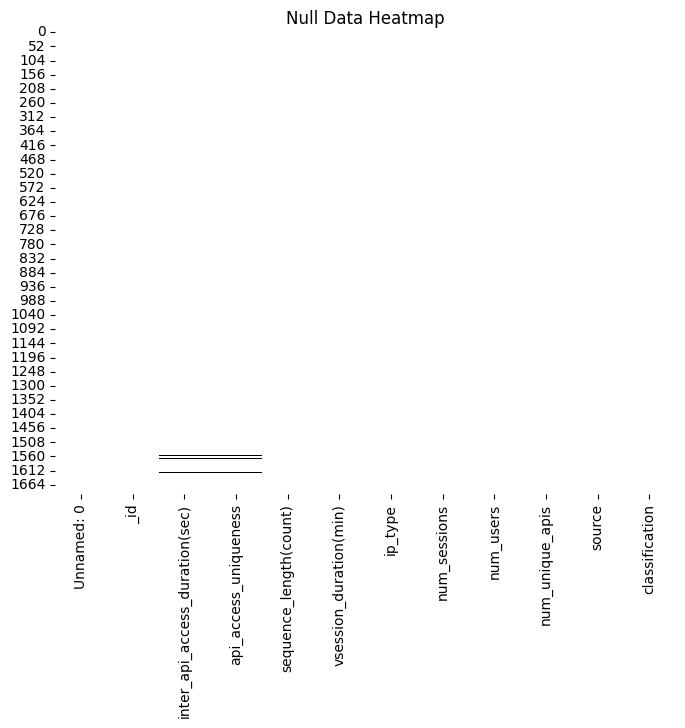

In [11]:
plt.figure(figsize=(8,6))
sns.heatmap(data.isnull(), cmap='Greys', cbar=False)
plt.title("Null Data Heatmap")
plt.show()

In [12]:
# columns_to_drop = [
#
# ]

# df = data[columns_to_drop].copy()

# data.drop(columns=columns_to_drop, inplace=True)
# print("Modified Original DataFrame:")
# print(data.head())

# print("\nNew DataFrame 'df':")
# print(df.head())

In [13]:
data_remain['inter_api_access_duration(sec)'].fillna(method='ffill', inplace=True)
data_remain['api_access_uniqueness'].fillna(method='ffill', inplace=True)

In [14]:
data_remain.isnull().sum()

Unnamed: 0                        0
_id                               0
inter_api_access_duration(sec)    0
api_access_uniqueness             0
sequence_length(count)            0
vsession_duration(min)            0
ip_type                           0
behavior                          0
behavior_type                     0
num_sessions                      0
num_users                         0
num_unique_apis                   0
source                            0
dtype: int64

# **Exploratory Data Analysis (EDA):**

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1699 entries, 0 to 1698
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Unnamed: 0                      1699 non-null   int64  
 1   _id                             1699 non-null   object 
 2   inter_api_access_duration(sec)  1695 non-null   float64
 3   api_access_uniqueness           1695 non-null   float64
 4   sequence_length(count)          1699 non-null   float64
 5   vsession_duration(min)          1699 non-null   int64  
 6   ip_type                         1699 non-null   object 
 7   num_sessions                    1699 non-null   float64
 8   num_users                       1699 non-null   float64
 9   num_unique_apis                 1699 non-null   float64
 10  source                          1699 non-null   object 
 11  classification                  1699 non-null   object 
dtypes: float64(6), int64(2), object(4)

In [16]:
data_remain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34423 entries, 0 to 34422
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Unnamed: 0                      34423 non-null  int64  
 1   _id                             34423 non-null  object 
 2   inter_api_access_duration(sec)  34423 non-null  float64
 3   api_access_uniqueness           34423 non-null  float64
 4   sequence_length(count)          34423 non-null  float64
 5   vsession_duration(min)          34423 non-null  int64  
 6   ip_type                         34423 non-null  object 
 7   behavior                        34423 non-null  object 
 8   behavior_type                   34423 non-null  object 
 9   num_sessions                    34423 non-null  float64
 10  num_users                       34423 non-null  float64
 11  num_unique_apis                 34423 non-null  float64
 12  source                          

count    34423.000000
mean        20.549411
std         77.844313
min          0.000000
25%          0.381743
50%          2.205333
75%          9.496915
max       2333.627333
Name: inter_api_access_duration(sec), dtype: float64


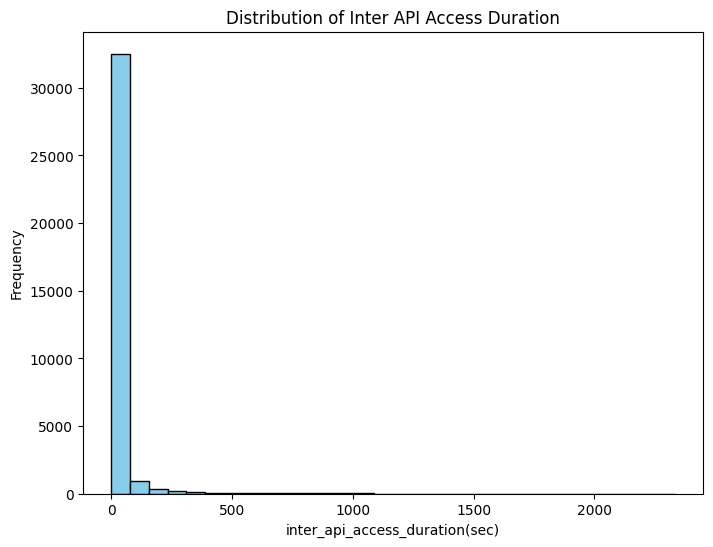

In [17]:
print(data_remain['inter_api_access_duration(sec)'].describe())

# Histogram for 'Packet Length'
plt.figure(figsize=(8, 6))
plt.hist(data_remain['inter_api_access_duration(sec)'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('inter_api_access_duration(sec)')
plt.ylabel('Frequency')
plt.title('Distribution of Inter API Access Duration')
plt.show()


**`"Inter API Access Duration" `**typically refers to the period during which an application or service has access to another application's programming interface (API) to retrieve or manipulate data.

For instance, when an application uses an API provided by another service (like accessing weather data from a weather service), the access duration refers to how long the first application can continue to utilize that API before it needs to renew or re-authenticate its access.

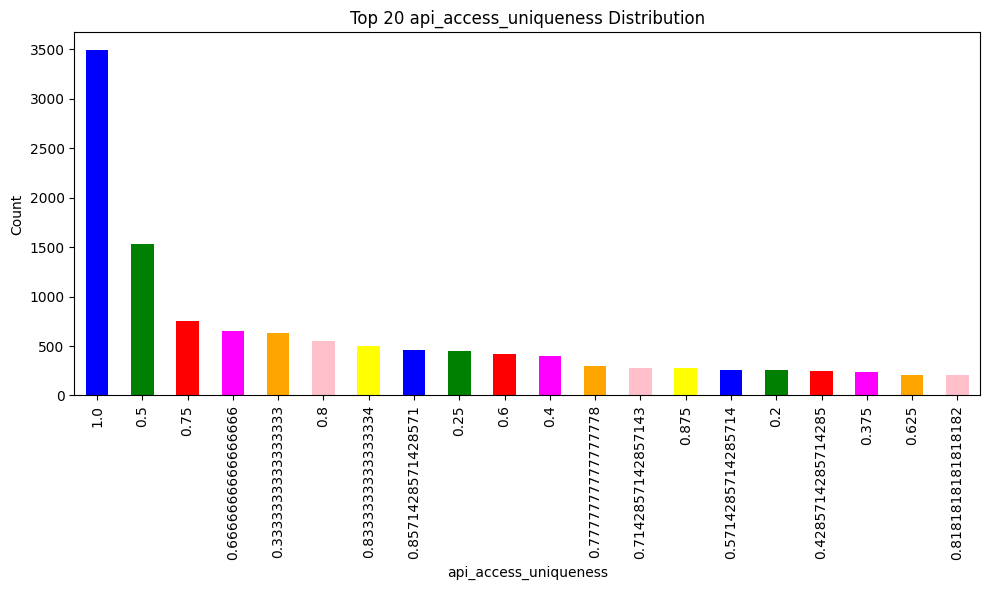

In [18]:
# Top 20 access uniqueness
top_20_access_uniqueness = data_remain['api_access_uniqueness'].value_counts().head(20)

colors = ['blue', 'green', 'red', 'magenta', 'orange', 'pink', 'yellow']
# 'Packet Type' frequencies
plt.figure(figsize=(10, 6))
top_20_access_uniqueness.plot(kind='bar', color=colors)
plt.xlabel('api_access_uniqueness')
plt.ylabel('Count')
plt.title('Top 20 api_access_uniqueness Distribution')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Measuring **API access uniqueness** involves assessing how distinct or varied the usage patterns are across different API access instances or users. It aims to quantify the diversity or individuality within the API usage.

Monitoring uniqueness helps detect unusual or unauthorized access patterns, which could indicate security breaches or misuse. Understanding how diverse API access is can help allocate resources better. For instance, identifying popular versus less-used endpoints can aid in resource optimization.

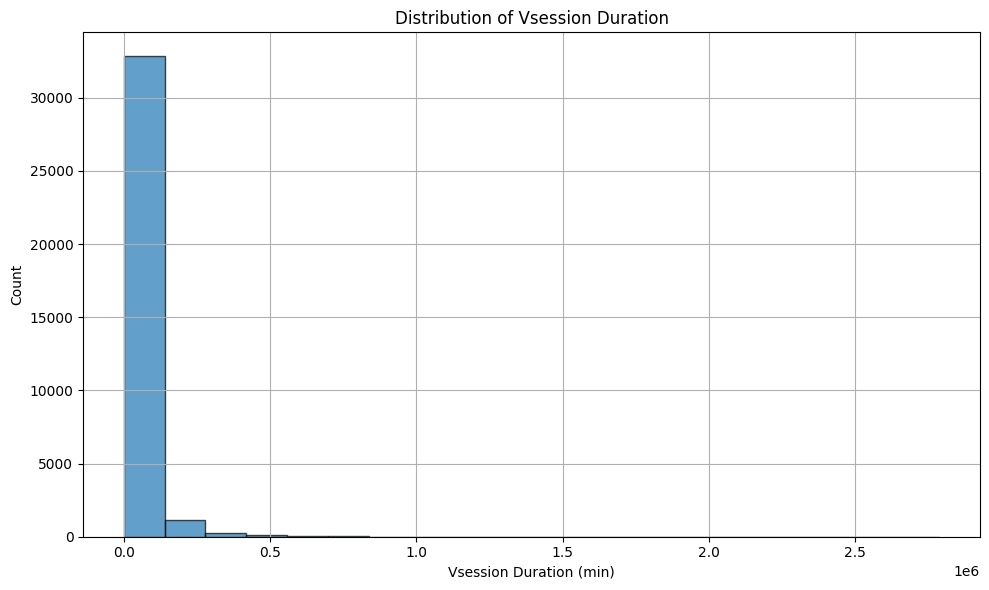

In [19]:
# Create a histogram for 'vsession_duration(min)'
plt.figure(figsize=(10, 6))
data_remain['vsession_duration(min)'].hist(bins=20, edgecolor='black', alpha=0.7)
plt.xlabel('Vsession Duration (min)')
plt.ylabel('Count')
plt.title('Distribution of Vsession Duration')
plt.grid(True)
plt.tight_layout()
plt.show()

**"Vsession Duration (min)"** typically refers to the duration of a virtual session measured in minutes. This metric quantifies the amount of time a user or a system remains actively engaged or connected within a virtual environment, platform, or system.

 Longer Vsession Durations often indicate higher user engagement or prolonged usage of a platform or service, which can be an essential metric for evaluating the success or popularity of an online platform.

<ipython-input-20-41818dfdb3be>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = data_remain.corr(method='kendall')


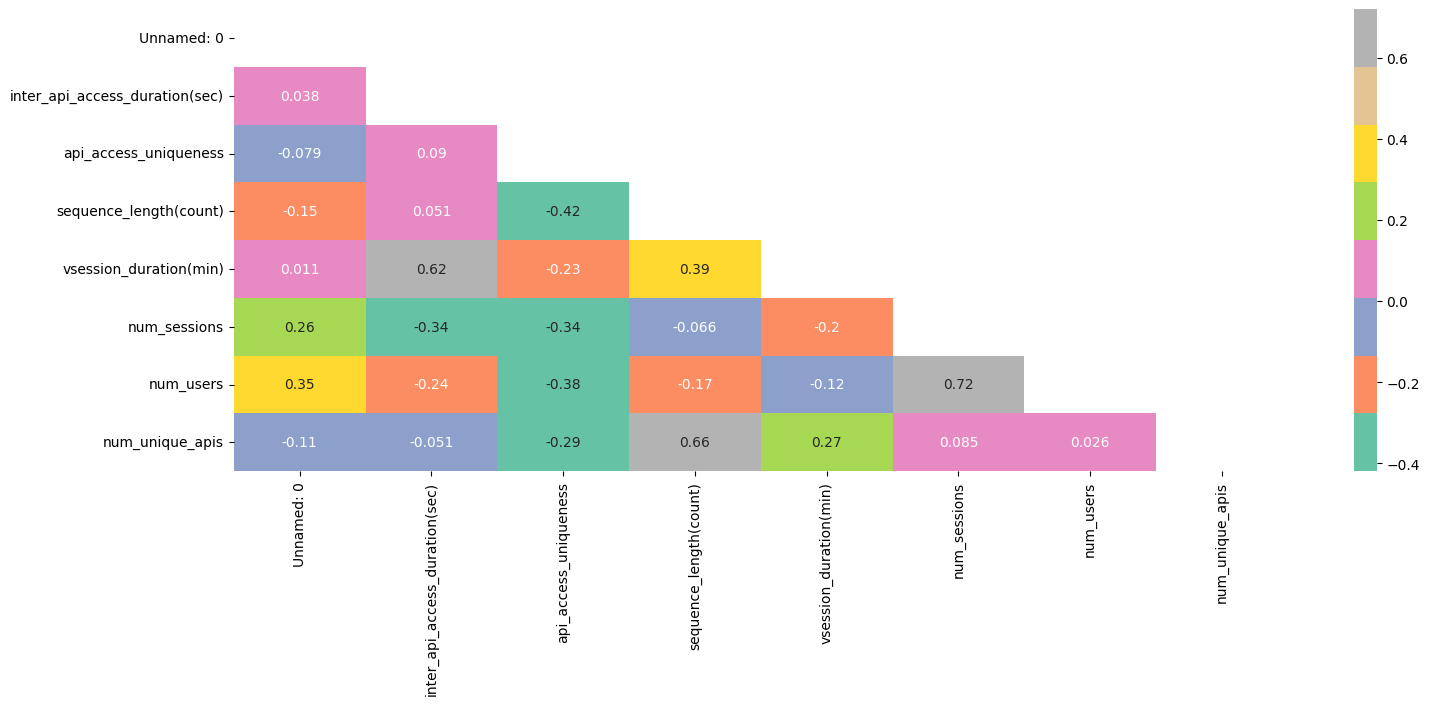

In [20]:
plt.figure(figsize=(17,6))
corr = data_remain.corr(method='kendall')
map = np.triu(corr)
sns.heatmap(corr, mask=map, annot=True, cmap='Set2')
plt.show()

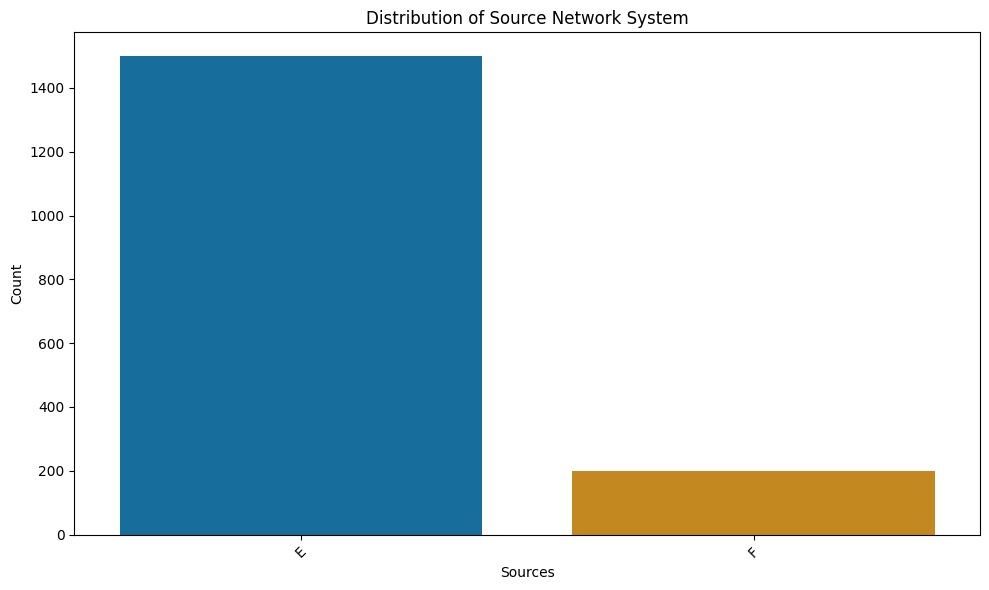

In [21]:
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='source', palette='colorblind')
plt.xlabel('Sources')
plt.ylabel('Count')
plt.title('Distribution of Source Network System')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## **Feature Transformation**

In [22]:
# Label Encoding

In [23]:
label = LabelEncoder()

data_remain['type_ip'] = label.fit_transform(data_remain['ip_type'])
data_remain['type_behaviour'] = label.fit_transform(data_remain['behavior_type'])
data_remain['source_type'] = label.fit_transform(data_remain['source'])
data_remain['behaviour']= label.fit_transform(data_remain['behavior'])

In [24]:
# Splitting Training-Testing-Validation Sets
x=data_remain[['inter_api_access_duration(sec)','api_access_uniqueness', 'sequence_length(count)','vsession_duration(min)','type_behaviour' ,'behaviour','num_sessions', 'num_users', 'num_unique_apis']]
y=data_remain['source_type']
x_train,x_test,y_train,y_test=train_test_split(x,y)

In [25]:
data_remain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34423 entries, 0 to 34422
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Unnamed: 0                      34423 non-null  int64  
 1   _id                             34423 non-null  object 
 2   inter_api_access_duration(sec)  34423 non-null  float64
 3   api_access_uniqueness           34423 non-null  float64
 4   sequence_length(count)          34423 non-null  float64
 5   vsession_duration(min)          34423 non-null  int64  
 6   ip_type                         34423 non-null  object 
 7   behavior                        34423 non-null  object 
 8   behavior_type                   34423 non-null  object 
 9   num_sessions                    34423 non-null  float64
 10  num_users                       34423 non-null  float64
 11  num_unique_apis                 34423 non-null  float64
 12  source                          

In [26]:
x_train.shape

(25817, 9)

In [27]:
y_train.shape

(25817,)

In [28]:
x_test.shape

(8606, 9)

In [29]:
y_test.shape

(8606,)

In [47]:
numerical_columns = ['inter_api_access_duration(sec)', 'vsession_duration(min)']

# Handling missing values by replacing them with zeros
data[numerical_columns] = data[numerical_columns].fillna(0)

# T-test for two numerical columns
t_stat, p_val = ttest_ind(data['inter_api_access_duration(sec)'], data['vsession_duration(min)'])
print(f"T-test p-value: {p_val}")
# Correlation analysis
correlation_matrix = data.corr()

# Categorical analysis
categorical_columns = ['ip_type', 'behavior', 'behavior_type', 'source', 'type_ip', 'type_behaviour', 'source_type', 'behaviour']
for col in categorical_columns:
    print(data_remain[col].value_counts())  # Frequency analysis
    contingency_table = pd.crosstab(data_remain[col], data_remain['source_type'])  # Replace 'target_column' with your dependent variable
    chi2, p, _, _ = chi2_contingency(contingency_table)
    print(f"Chi-square p-value for {col}: {p}")

# Inferential analysis (example - t-test for two numerical columns)
t_stat, p_val = ttest_ind(data['inter_api_access_duration(sec)'], data['vsession_duration(min)'])
print(f"T-test p-value: {p_val}")

# Linear regression example
X = data_remain[['num_sessions', 'num_users', 'num_unique_apis', 'inter_api_access_duration(sec)', 'api_access_uniqueness', 'sequence_length(count)']]
y = data_remain['source_type']
X = sm.add_constant(X)  # Adding constant for the intercept term
model = sm.OLS(y, X).fit()
print(model.summary())

T-test p-value: 1.0743200281745297e-07
default       32900
private_ip     1384
datacenter      138
google_bot        1
Name: ip_type, dtype: int64
Chi-square p-value for ip_type: 6.583369196081505e-50
outlier                                             24146
Normal                                               8946
Googlebot/2.1                                          95
BingPreview/1.0b                                       94
Googlebot/2.1;unknown                                  93
                                                    ...  
AdsBot-Google;Chrome                                    1
SemrushBot-SA/0.97;unknown                              1
Mobile Safari;bingbot/2.0                               1
Firefox;Python-requests                                 1
Chrome;Chrome Mobile;Googlebot/2.1;Mobile Safari        1
Name: behavior, Length: 75, dtype: int64
Chi-square p-value for behavior: 0.0
outlier    24146
normal      8946
bot         1309
attack        22
Name: behavior_

<ipython-input-47-50c9a472ee42>:11: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data.corr()


Chi-square p-value for type_ip: 6.583369196081505e-50
3    24146
2     8946
1     1309
0       22
Name: type_behaviour, dtype: int64
Chi-square p-value for type_behaviour: 0.0
0    17789
1    16634
Name: source_type, dtype: int64
Chi-square p-value for source_type: 0.0
74    24146
58     8946
53       95
34       94
55       93
      ...  
12        1
65        1
57        1
50        1
44        1
Name: behaviour, Length: 75, dtype: int64
Chi-square p-value for behaviour: 0.0
T-test p-value: 1.0743200281745297e-07
                            OLS Regression Results                            
Dep. Variable:            source_type   R-squared:                       0.153
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     1038.
Date:                Wed, 22 Nov 2023   Prob (F-statistic):               0.00
Time:                        20:51:42   Log-Likelihood:                -22101.
No. O

## **Inferential Statistical Analysis of the Result Given by Ordinary Least Squares For all Features Given in the dataset**

### T-test:
- The T-test between **`'inter_api_access_duration(sec)'`** and **`'vsession_duration(min)'`** yielded a p-value of 1.07e-07, indicating a statistically significant difference between these two variables. This suggests that these two variables might have differing impacts on the 'source_type'.

### Chi-square tests:
- **ip_type, behavior, behavior_type, source, type_ip, type_behaviour, source_type, and behaviour:**
  - All of these categorical variables exhibit highly significant associations with the **`'source_type'`** (p-values close to zero). This implies that these categorical variables are potentially strong predictors or indicators of the 'source_type'.

### OLS Regression:
- The regression model with predictors `**num_sessions**`, `**num_users**`, `**num_unique_apis**`,** `inter_api_access_duration(sec)`** , **Inline code**, `**api_access_uniqueness**`, and `**sequence_length(count)**` explains approximately 15.3% of the variance in the 'source_type'.
- Individual predictors:
  - **num_sessions, num_users, num_unique_apis, inter_api_access_duration(sec), api_access_uniqueness, and sequence_length(count):**
    - All of these predictors show statistically significant coefficients (p-values close to zero), indicating that each has a significant impact on predicting the 'source_type' when considered independently.
  - **const (intercept term):**
    - The intercept term is also statistically significant, suggesting that even without any predictors, there exists a baseline effect on the 'source_type'.
- The model's **low R-squared value (15.3%)** indicates that while these predictors significantly contribute to explaining the 'source_type', a substantial portion of the variability in 'source_type' remains unexplained by this model.

### Overall Analysis:
- The findings indicate that both numerical and categorical variables have strong relationships with the target variable 'source_type'. However, while the relationships are statistically significant, the explanatory power of the model remains moderate (R-squared of 15.3%). Other unexplored factors may contribute to the variability in 'source_type' not accounted for by these variables.

### **Hyperparameter Tuning and Setting Up Boosting Algorithms (AdaBoost, Gradient Boost, XGBoost)**

In [30]:
# Define the hyperparameter search space
ada_params = {
    'n_estimators': [50, 100, 200], #  representing the number of estimators (decision trees) in the AdaBoost ensemble
    'learning_rate': [0.01, 0.1, 0.2] # learning rate of the AdaBoost algorithm, controlling the contribution of each classifier in the ensemble.
}

# Train and evaluate the AdaBoostClassifier model using GridSearchCV
ada_clf = AdaBoostClassifier(random_state=42)
ada_grid = GridSearchCV(ada_clf, ada_params, error_score='raise', cv=5, scoring='accuracy')
ada_grid.fit(x_train, y_train)

# Print the best hyperparameters for AdaBoost
print("Best Hyperparameters for AdaBoost:", ada_grid.best_params_)


Best Hyperparameters for AdaBoost: {'learning_rate': 0.2, 'n_estimators': 200}


In [31]:
# Define the hyperparameter search space
gb_params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 4, 6]
}

gb_clf = GradientBoostingClassifier(random_state=42)
gb_grid = GridSearchCV(gb_clf, gb_params, cv=5, scoring='accuracy')
gb_grid.fit(x_train, y_train)

# Print the best hyperparameters for Gradient Boosting
print("Best Hyperparameters for Gradient Boosting:", gb_grid.best_params_)

Best Hyperparameters for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 7, 'min_samples_split': 2, 'n_estimators': 50}


In [32]:
# Define the hyperparameter search space
xgb_params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5]
}

xgb_clf = xgb.XGBClassifier(random_state=42)
xgb_grid = GridSearchCV(xgb_clf, xgb_params, cv=5, scoring='accuracy')
xgb_grid.fit(x_train, y_train)

# Print the best hyperparameters for XGBoost
print("Best Hyperparameters for XGBoost:", xgb_grid.best_params_)

Best Hyperparameters for XGBoost: {'learning_rate': 0.2, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 50}


In [33]:


# Evaluate the models on the testing set
ada_predictions = ada_grid.best_estimator_.predict(x_test)
gb_predictions = gb_grid.best_estimator_.predict(x_test)
xgb_predictions = xgb_grid.best_estimator_.predict(x_test)

# Evaluate accuracy
ada_accuracy = accuracy_score(y_test, ada_predictions)
gb_accuracy = accuracy_score(y_test, gb_predictions)
xgb_accuracy = accuracy_score(y_test, xgb_predictions)

# Evaluation metrics
ada_report = classification_report(y_test, ada_predictions)
gb_report = classification_report(y_test, gb_predictions)
xgb_report = classification_report(y_test, xgb_predictions)

ada_confusion_matrix = confusion_matrix(y_test, ada_predictions)
gb_confusion_matrix = confusion_matrix(y_test, gb_predictions)
xgb_confusion_matrix = confusion_matrix(y_test, xgb_predictions)


print(f"Accuracy for AdaBoost: {ada_accuracy:.2f}")
print(f"Accuracy for Gradient Boosting: {gb_accuracy:.2f}")
print(f"Accuracy for XGBoost: {xgb_accuracy:.2f}")

# Additional metrics and information
print("\nClassification Report for AdaBoost:")
print(ada_report)
print("\nConfusion Matrix for AdaBoost:")
print(ada_confusion_matrix)

print("\nClassification Report for Gradient Boosting:")
print(gb_report)
print("\nConfusion Matrix for Gradient Boosting:")
print(gb_confusion_matrix)

print("\nClassification Report for XGBoost:")
print(xgb_report)
print("\nConfusion Matrix for XGBoost:")
print(xgb_confusion_matrix)

Accuracy for AdaBoost: 0.83
Accuracy for Gradient Boosting: 0.86
Accuracy for XGBoost: 0.86

Classification Report for AdaBoost:
              precision    recall  f1-score   support

           0       0.80      0.90      0.84      4490
           1       0.87      0.75      0.81      4116

    accuracy                           0.83      8606
   macro avg       0.83      0.82      0.83      8606
weighted avg       0.83      0.83      0.83      8606


Confusion Matrix for AdaBoost:
[[4034  456]
 [1027 3089]]

Classification Report for Gradient Boosting:
              precision    recall  f1-score   support

           0       0.85      0.87      0.86      4490
           1       0.86      0.84      0.85      4116

    accuracy                           0.86      8606
   macro avg       0.86      0.85      0.85      8606
weighted avg       0.86      0.86      0.86      8606


Confusion Matrix for Gradient Boosting:
[[3914  576]
 [ 670 3446]]

Classification Report for XGBoost:
        

## **Accuracy Test Result**



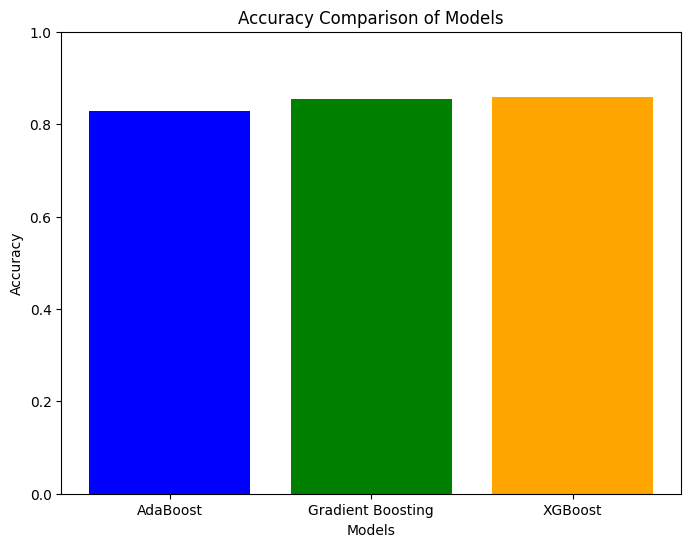

In [34]:
models = ['AdaBoost', 'Gradient Boosting', 'XGBoost']
accuracies = [ada_accuracy, gb_accuracy, xgb_accuracy]

plt.figure(figsize=(8,6))
plt.bar(models, accuracies, color=['blue', 'green', 'orange'])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title("Accuracy Comparison of Models")
plt.ylim(0, 1)
plt.show()

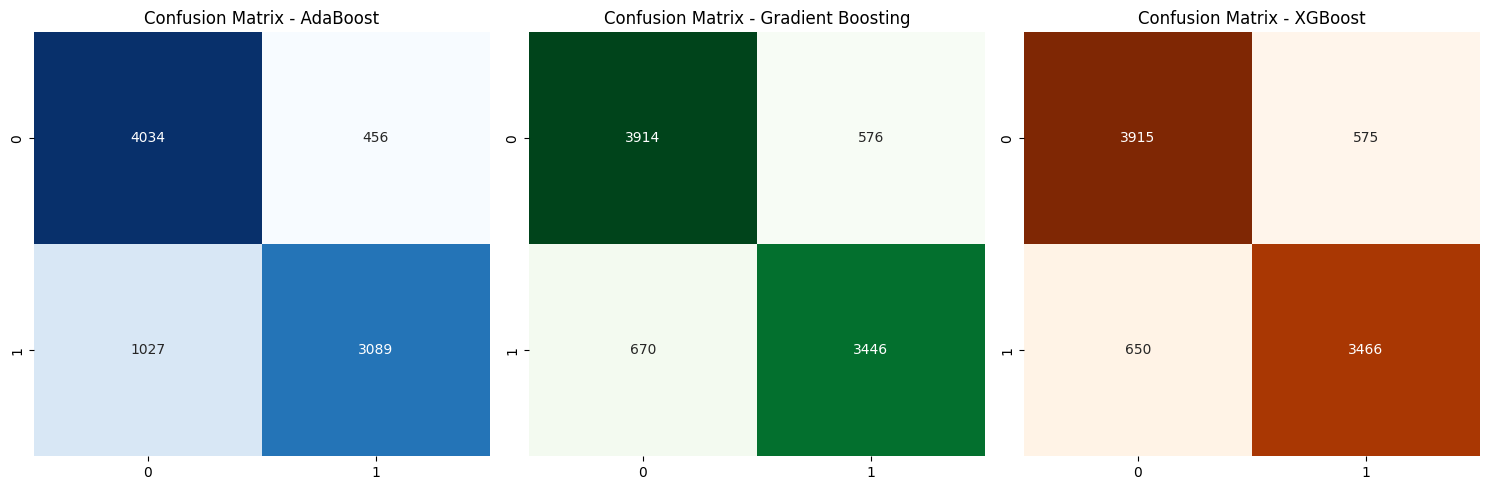

In [35]:
plt.figure(figsize=(15, 5))

# Confusion Matrix for AdaBoost
plt.subplot(1, 3, 1)
sns.heatmap(ada_confusion_matrix, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.title('Confusion Matrix - AdaBoost')

# Confusion Matrix for Gradient Boosting
plt.subplot(1, 3, 2)
sns.heatmap(gb_confusion_matrix, annot=True, cmap='Greens', fmt='d', cbar=False)
plt.title('Confusion Matrix - Gradient Boosting')

# Confusion Matrix for XGBoost
plt.subplot(1, 3, 3)
sns.heatmap(xgb_confusion_matrix, annot=True, cmap='Oranges', fmt='d', cbar=False)
plt.title('Confusion Matrix - XGBoost')

plt.tight_layout()
plt.show()


### **Finding Feature Importance and Hyperparameter Sensitivity for All Boosting Algorithms**

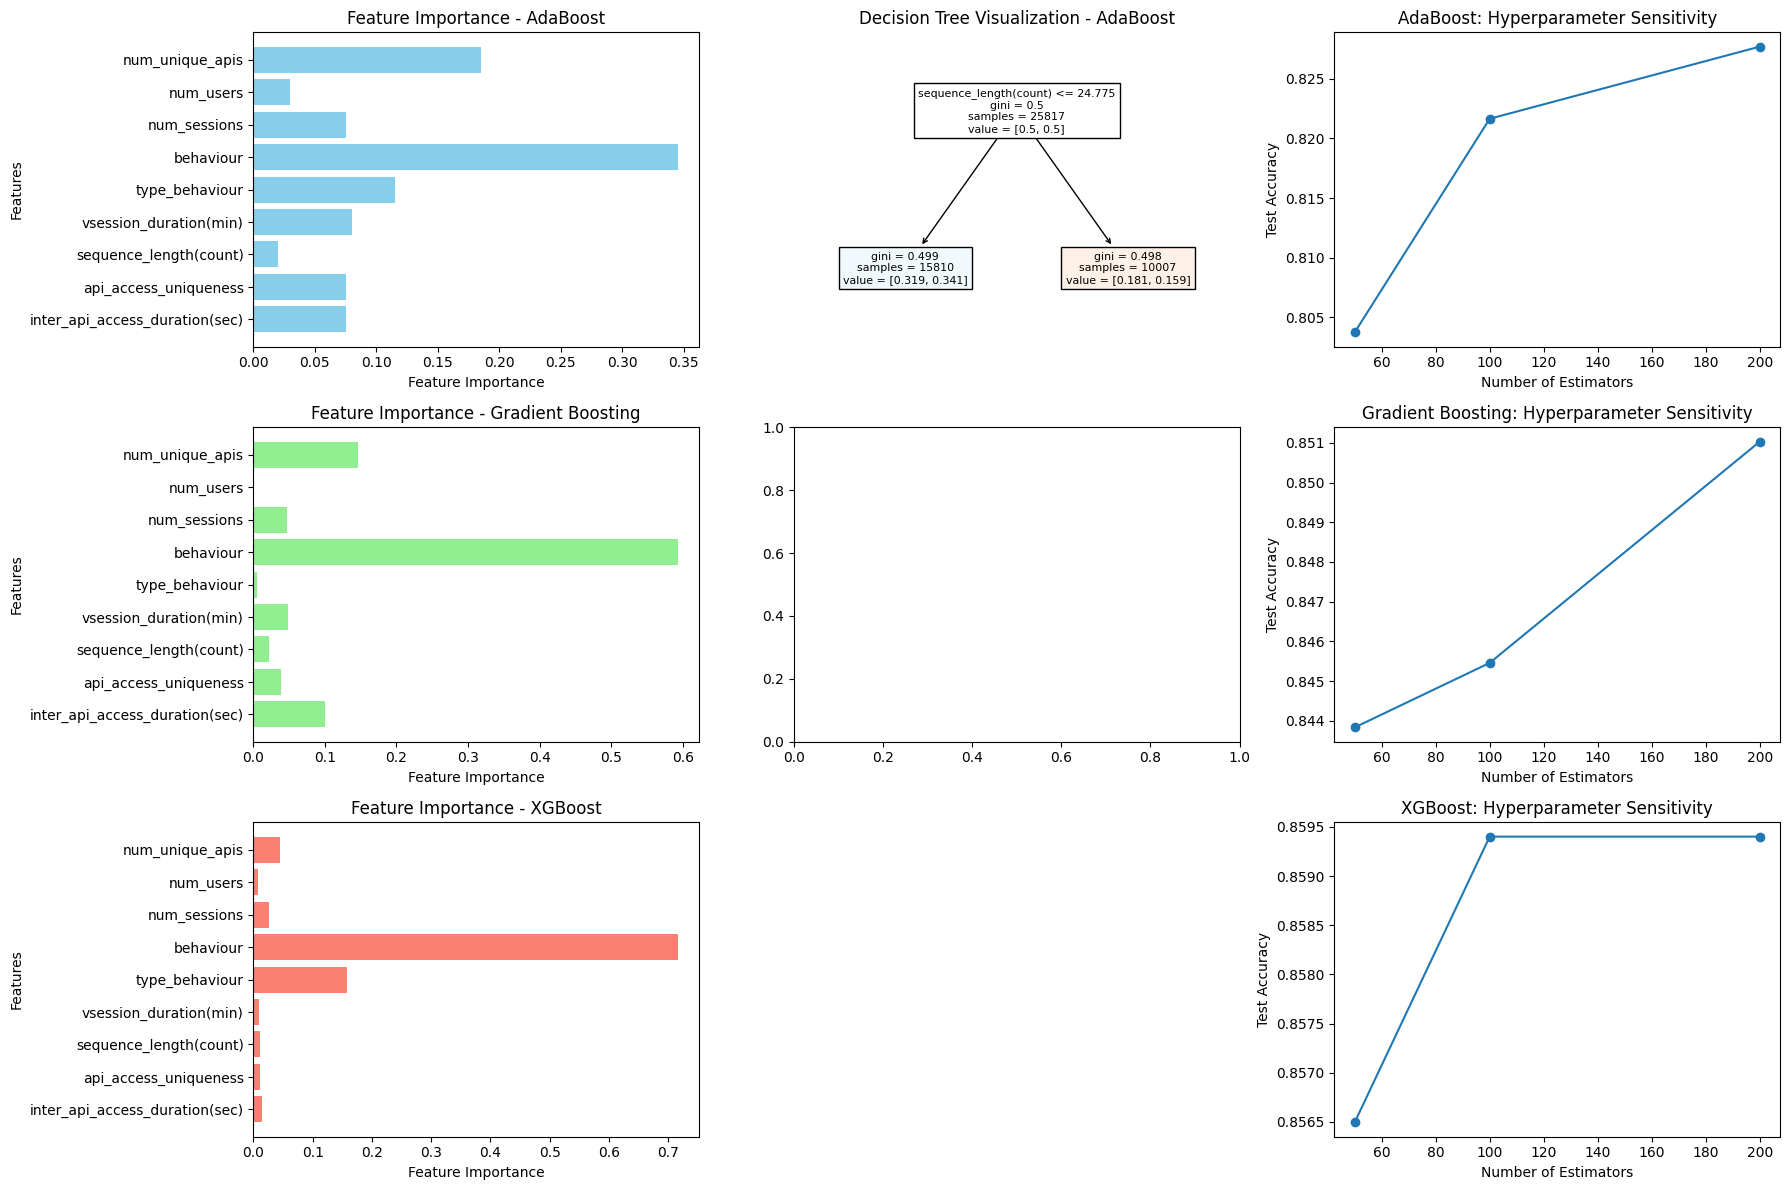

In [36]:

ada_model = AdaBoostClassifier(**ada_grid.best_params_, random_state=42)
gb_model = GradientBoostingClassifier(**ada_grid.best_params_, random_state=42)
xgb_model = xgb.XGBClassifier(**ada_grid.best_params_, random_state=42)

models = [ada_model, gb_model, xgb_model]
model_names = ['AdaBoost', 'Gradient Boosting', 'XGBoost']
params=[ada_params, gb_params, xgb_params]
features = ['inter_api_access_duration(sec)', 'api_access_uniqueness', 'sequence_length(count)',
            'vsession_duration(min)', 'type_behaviour', 'behaviour', 'num_sessions',
            'num_users', 'num_unique_apis']

plt.figure(figsize=(18,12))
for i, model in enumerate(models):
  # Feature Importance Extraction Process
  model.fit(x_train, y_train)
  feature_importance = model.feature_importances_

  plt.subplot(3 , 3, i*3 + 1)
  plt.barh(features, feature_importance, color=['skyblue', 'lightgreen', 'salmon'][i])
  plt.xlabel('Feature Importance')
  plt.ylabel('Features')
  plt.title(f'Feature Importance - {model_names[i]}')


  # Model Interpretability (if applicable)
  if model_names[i] != 'XGBoost':
    plt.subplot(3, 3, i*3 + 2)
    if hasattr(model, 'estimators_'):
      for est in model.estimators_:
        if hasattr(est, 'tree_'):
          plot_tree(est, filled=True, feature_names=features)  # Visualize The Tree
          plt.title(f"Decision Tree Visualization - {model_names[i]}")


  # Hyper Parameter Sensitivity Check For All Three Boosting Algorithm
  plt.subplot(3, 3, i*3 + 3)
  test_accuracies = []
  for param in params[i]['n_estimators']:
    model.set_params(**{list(params[i].keys())[0]: param})
    model.fit(x_train, y_train)
    test_accuracy = model.score(x_test, y_test)
    test_accuracies.append(test_accuracy)

  plt.plot(params[i]['n_estimators'], test_accuracies, marker='o')
  plt.xlabel('Number of Estimators')
  plt.ylabel('Test Accuracy')
  plt.title(f"{model_names[i]}: Hyperparameter Sensitivity")

plt.tight_layout()
plt.show()


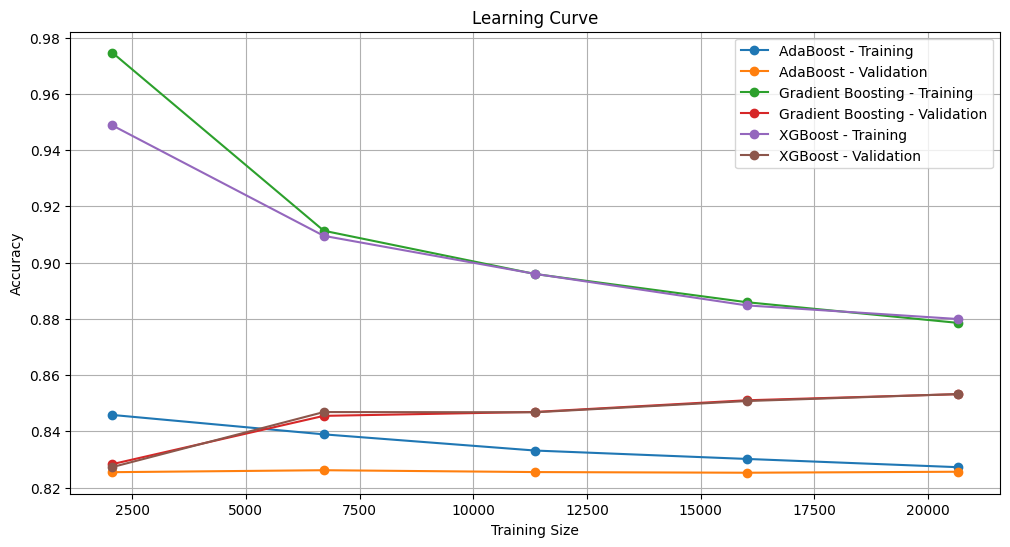

In [37]:
models = [ada_grid.best_estimator_, gb_grid.best_estimator_, xgb_grid.best_estimator_]
model_names = ['AdaBoost', 'Gradient Boosting', 'XGBoost']

plt.figure(figsize=(12, 6))

for model, name in zip(models, model_names):
  train_sizes, train_scores, val_scores = learning_curve(model, x_train, y_train, cv=5, scoring='accuracy')
  train_mean = np.mean(train_scores, axis=1)
  val_mean = np.mean(val_scores, axis=1)
  plt.plot(train_sizes, train_mean, label=f'{name} - Training', marker='o')
  plt.plot(train_sizes, val_mean, label=f'{name} - Validation', marker='o')

plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend()
plt.grid()
plt.show()


### **Plotting ROC-AUC Curve**

**`ROC-AUC (Receiver Operating Characteristic - Area Under Curve)`** is a useful metric for understanding the discriminative power of a binary classifier. It illustrates the classifier's ability to distinguish between classes by plotting the trade-off between true positive rate (sensitivity) and false positive rate (1 - specificity) across various thresholds.

Boosting algorithms often excel in handling imbalanced datasets where one class dominates the other. ROC-AUC is a preferred metric in such cases as it's less affected by class imbalance and provides a comprehensive view of classifier performance across different thresholds.

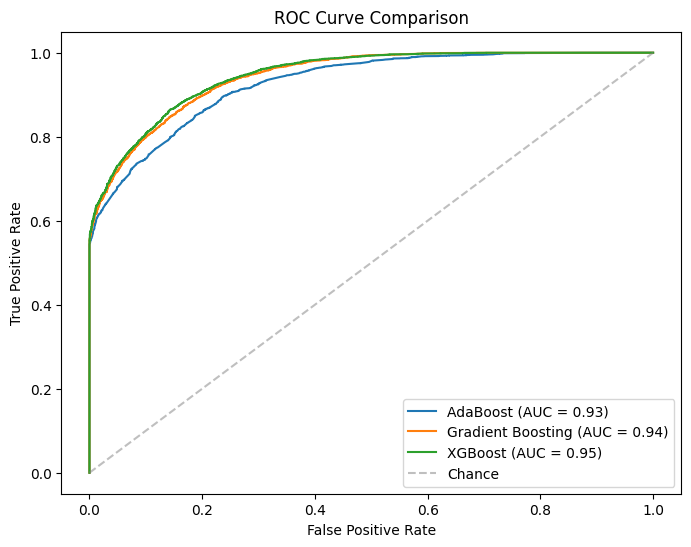

In [ ]:
plt.figure(figsize=(8, 6))